In [1]:
import torch
from transformers import Trainer, TrainingArguments
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import os
from datasets import load_dataset,load_metric
# from evaluate import load_metric
from sklearn.model_selection import train_test_split

device = 'cuda:0'

### Data

In [2]:
# Load the Samsum dataset
dataset = load_dataset("samsum")

train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

In [3]:
# Tokenzing
def tokenize_function(tokenizer,examples):
#     print(examples['dialogue'])
    input_dialogues = ["Summarize dialogue >>\n " + dialogue for dialogue in examples["dialogue"]]

    #     input_dialog = f"""{examples["dialogue"]}"""

    inputs = tokenizer(input_dialogues, padding="max_length", truncation=True, max_length=1000)
    targets = tokenizer(examples["summary"], padding="max_length", truncation=True, max_length=100)
#     if len(inputs['input_ids']) > 1000:
#         inputs = tokenizer(input_dialog, padding="max_length", truncation=True, max_length=1000)
#     if len(targets['input_ids']) > 100:
#         targets = tokenizer(examples["summary"], padding="max_length", truncation=True, max_length=100)
    
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": targets["input_ids"]}

### Model - BART

In [4]:
model_name = "facebook/bart-base"
bart_base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
bart_base_tokenizer = AutoTokenizer.from_pretrained(model_name)
bart_base = (bart_base_model,bart_base_tokenizer)

In [6]:
def summarize(tokenizer,model,text):
    inputs = tokenizer(f"Summarize dialogue >>\n {text}", return_tensors="pt", max_length=1000, truncation=True, padding="max_length").to(device)

    # Generate summary
    summary_ids = model.generate(inputs.input_ids, num_beams=4, max_length=100, early_stopping=True)
#     print(len(summary_ids[0]))
    # Decode the summary
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    return summary

# Example usage
text = train_data['dialogue'][5]
summary = summarize(bart_base_tokenizer,bart_base_model,text)
print("Generated Summary:"+ summary[0])

Generated Summary:Summarize dialogue >>Neville Neville: Hi there, does anyone remember what date I got married on?Wyatt: I don't know.Don: Are you serious?Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check. Don: What's the date?Don: It's September 17.Wy


In [7]:
"Summarize >> \n"+text

"Summarize >> \nNeville: Hi there, does anyone remember what date I got married on?\r\nDon: Are you serious?\r\nNeville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.\r\nWyatt: Hang on, I'll ask my wife.\r\nDon: Haha, someone's in a lot of trouble :D\r\nWyatt: September 17. I hope you remember the year ;)"

In [22]:
for name, param in bart_base_model.named_parameters():
    if param.requires_grad:
        print(name)


model.encoder.embed_positions.weight
model.encoder.layers.4.self_attn.k_proj.weight
model.encoder.layers.4.self_attn.k_proj.bias
model.encoder.layers.4.self_attn.v_proj.weight
model.encoder.layers.4.self_attn.v_proj.bias
model.encoder.layers.4.self_attn.q_proj.weight
model.encoder.layers.4.self_attn.q_proj.bias
model.encoder.layers.4.self_attn.out_proj.weight
model.encoder.layers.4.self_attn.out_proj.bias
model.encoder.layers.4.self_attn_layer_norm.weight
model.encoder.layers.4.self_attn_layer_norm.bias
model.encoder.layers.4.fc1.weight
model.encoder.layers.4.fc1.bias
model.encoder.layers.4.fc2.weight
model.encoder.layers.4.fc2.bias
model.encoder.layers.4.final_layer_norm.weight
model.encoder.layers.4.final_layer_norm.bias
model.encoder.layers.5.self_attn.k_proj.weight
model.encoder.layers.5.self_attn.k_proj.bias
model.encoder.layers.5.self_attn.v_proj.weight
model.encoder.layers.5.self_attn.v_proj.bias
model.encoder.layers.5.self_attn.q_proj.weight
model.encoder.layers.5.self_attn.q_p

In [9]:

total_params = sum(p.numel() for p in bart_base_model.parameters())
print("Total parameters:", total_params)

# trainable_params = sum(p.numel() for p in bart_base_model.parameters() if p.requires_grad)
# print("Trainable parameters:", trainable_params)        


for name, param in bart_base_model.named_parameters():
    if "encoder" in name and "layer" in name and "layernorm" not in name:
        layer_index = int(name.split('.')[3])  # Extract the layer index
        if layer_index < 4:  # Assuming BART has 12 encoder layers, keep last 2 layers trainable
            param.requires_grad = False            
            
for name, param in bart_base_model.named_parameters():
    if "encoder" not in name:  # Exclude parameters in the encoder
        param.requires_grad = False            
            
trainable_params_after_freeze = sum(p.numel() for p in bart_base_model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params_after_freeze)        
            

Total parameters: 139420416
Trainable parameters: 19693056


In [10]:
trainable_params_after_freeze/total_params

0.1412494422624589

In [11]:
for name, param in bart_base_model.named_parameters():
    if param.requires_grad:
        print(name)


model.encoder.embed_positions.weight
model.encoder.layers.4.self_attn.k_proj.weight
model.encoder.layers.4.self_attn.k_proj.bias
model.encoder.layers.4.self_attn.v_proj.weight
model.encoder.layers.4.self_attn.v_proj.bias
model.encoder.layers.4.self_attn.q_proj.weight
model.encoder.layers.4.self_attn.q_proj.bias
model.encoder.layers.4.self_attn.out_proj.weight
model.encoder.layers.4.self_attn.out_proj.bias
model.encoder.layers.4.self_attn_layer_norm.weight
model.encoder.layers.4.self_attn_layer_norm.bias
model.encoder.layers.4.fc1.weight
model.encoder.layers.4.fc1.bias
model.encoder.layers.4.fc2.weight
model.encoder.layers.4.fc2.bias
model.encoder.layers.4.final_layer_norm.weight
model.encoder.layers.4.final_layer_norm.bias
model.encoder.layers.5.self_attn.k_proj.weight
model.encoder.layers.5.self_attn.k_proj.bias
model.encoder.layers.5.self_attn.v_proj.weight
model.encoder.layers.5.self_attn.v_proj.bias
model.encoder.layers.5.self_attn.q_proj.weight
model.encoder.layers.5.self_attn.q_p

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


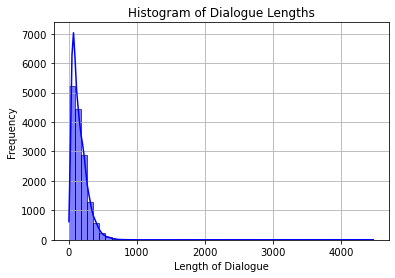

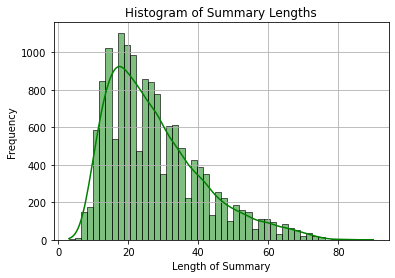

In [12]:
d_len = [len(bart_base_tokenizer.encode(s)) for s in train_data["dialogue"]]
s_len = [len(bart_base_tokenizer.encode(s)) for s in train_data["summary"]]

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(d_len, bins=50, color='blue', kde=True)
plt.xlabel('Length of Dialogue')
plt.ylabel('Frequency')
plt.title('Histogram of Dialogue Lengths')
plt.grid(True)
plt.show()

sns.histplot(s_len, bins=50, color='green', kde=True)
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')
plt.title('Histogram of Summary Lengths')
plt.grid(True)
plt.show()


In [13]:
sorted(s_len)[-10:]

[77, 78, 79, 79, 80, 81, 81, 82, 83, 90]

#### Training

In [14]:

#Tokenizing data
train_data_tokenized = train_data.map(lambda examples: tokenize_function(bart_base_tokenizer, examples), batched=True)
validation_data_tokenized = validation_data.map(lambda examples: tokenize_function(bart_base_tokenizer, examples), batched=True)
test_data_tokenized = test_data.map(lambda examples: tokenize_function(bart_base_tokenizer, examples), batched=True)



Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [15]:
output_dir = "./bart_base"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [19]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=3,
    num_train_epochs=1,
    learning_rate=1e-4,
)

rouge_metric = load_metric("rouge")

# trainer = Trainer(
#     model=bart_base_model,
#     args=training_args,
#     train_dataset=train_data_tokenized,
#     eval_dataset=validation_data_tokenized,
#     compute_metrics=lambda pred: rouge_metric.compute(predictions=pred.predictions, references=pred.label_ids)
# )

trainer = Trainer(
    model=bart_base_model,
    args=training_args,
    train_dataset=train_data_tokenized
)

/home/sampgaon.h/.local/lib/python3.8/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [20]:
trainer.train()

/home/sampgaon.h/.local/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.319700,No log
1,4.319700,No log
1,4.319700,No log


OutOfMemoryError: CUDA out of memory. Tried to allocate 634.00 MiB. GPU 0 has a total capacty of 14.58 GiB of which 596.44 MiB is free. Including non-PyTorch memory, this process has 13.99 GiB memory in use. Of the allocated memory 12.90 GiB is allocated by PyTorch, and 988.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
trainer.save_model(output_dir)


eval_trainer = Trainer(
    model=bart_base_model,
    compute_metrics=lambda pred: rouge_metric.compute(predictions=pred.predictions, references=pred.label_ids)
)

# Evaluate the model on the test set
results = eval_trainer.evaluate(test_data)
results = trainer.evaluate(test_data)
print("ROUGE scores:", results)

ROUGE scores: {}


In [25]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_data,
#     eval_dataset=validation_data,
#     compute_metrics=lambda pred: rouge_metric.compute(predictions=pred.predictions, references=pred.label_ids)
# )

latest_checkpoint = trainer.model_checkpoint.last_checkpoint

if latest_checkpoint is not None:
    print("Loading latest checkpoint:", latest_checkpoint)
    model = AutoModelForSeq2SeqLM.from_pretrained(latest_checkpoint)
else:
    print("No checkpoint found in", output_dir)

AttributeError: 'Trainer' object has no attribute 'model_checkpoint'

## Some code test do not run